### Gamma power comparison between SD and NSD REM sleep
- from whitened lfp spectrogram it appears that there maybe stronger gamma oscillation during REM of recovery sleep compared to REM of NSD sleep

In [35]:
import numpy as np
import pandas as pd
import subjects

# sessions = subjects.nsd.brainstates_sess + subjects.sd.brainstates_sess
sessions = subjects.nsd.ratUday2 + subjects.sd.ratUday4

In [55]:
import scipy.signal as sg
from scipy import stats

psd_df = []
for sub,sess in enumerate(sessions):
    post = sess.paradigm['post'].flatten()
    if sess.tag=='SD':
        period = [post[0]+5*3600,post[1]] 
    else:
        period = [post[0],post[0]+5*3600]

    states= sess.brainstates.time_slice(period[0],period[1])['rem']
    channel = sess.ripple.metadata['channels'][3]
    trace = sess.eegfile.get_frames_within_epochs(states,82)
    b,a = sg.iirnotch(60,50,fs=1250)
    trace = sg.filtfilt(b,a,trace)
    trace = stats.zscore(trace)

    f,psd = sg.welch(trace,fs=1250,nperseg=1250,noverlap=250)

    df = pd.DataFrame(dict(freqs=f,psd=psd,grp=sess.tag))
    psd_df.append(df) 

psd_df = pd.concat(psd_df,ignore_index=True)

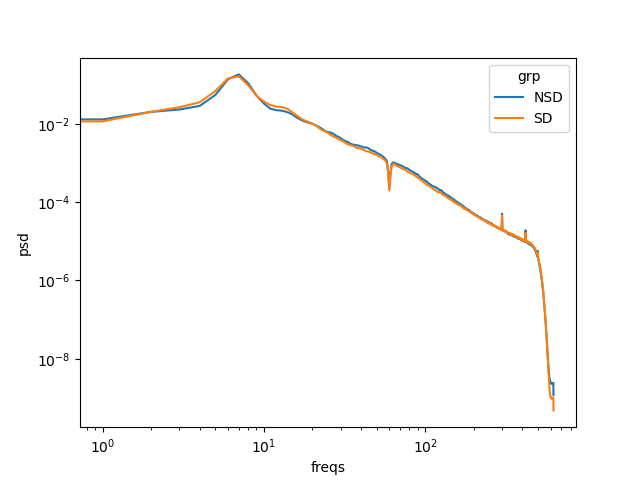

In [56]:
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns

_,ax = plt.subplots()
sns.lineplot(data=psd_df,x='freqs',y='psd',hue='grp',ax=ax)
ax.set_xscale('log')
ax.set_yscale('log')